# Setup

In [1]:
from idrtools import math
from twins_embedding import TwinsEmbeddingAnalysis
from matplotlib import pyplot as plt
from matplotlib import colors
from tqdm.notebook import tqdm
from astropy.table import Table
import utils
import numpy as np

/home/kyle/supernova/snfactory/manifold_twins/analysis/twins_embedding.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline

In [3]:
a = TwinsEmbeddingAnalysis()
a.settings['figure_directory'] = './output_generation/figures/'
a.settings['latex_directory'] = './output_generation/latex/'
a.run_analysis()

Loading dataset...
    IDR:          BLACKSTON
    Phase range: [-5.0, 5.0] days
    Bin velocity: 1000.0


  0%|          | 0/415 [00:00<?, ?it/s]

Estimating the spectra at maximum light...
    Loaded cached stan model
    Using saved stan result
Reading between the lines...
    Loaded cached stan model
    Using saved stan result
Building masks...
    Masking 30/203 targets whose uncertainty power is 
    more than 0.100 of the intrinsic power.
Generating the manifold learning embedding...
Loading other indicators of diversity...
Fitting RBTL Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.073 ± 0.008
    gp_kernel_amplitude       0.164 ± 0.082
    gp_length_scale           5.541 ± 3.315
    offset                    -0.116 ± 0.124
    covariate_slope_0         -0.122 ± 0.051
    Fit NMAD                  0.083 mag
    Fit std                   0.101 mag
Fitting SALT2 Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.085

# Recovering other indicators of intrinsic diversity

## Choose the indicators to use

In [4]:
isomap_indicators = [
    'isomap_c1',
    'isomap_c2',
    'isomap_c3',
]

sugar_indicators = [
    'sugar_q1',
    'sugar_q2',
    'sugar_q3',
]

snemo_indicators = [
    'snemo7_c1',
    'snemo7_c2',
    'snemo7_c3',
    'snemo7_c4',
    'snemo7_c5',
    'snemo7_c6',
]

salt_indicators = [
    'salt_x1',
]

target_indicators = {
    'spectrum_EWCaIIHK' : 'pEW CaII HK',
    'spectrum_EWSiII4000': 'pEW SiII 4000 $\AA$',
    'spectrum_EWSiII5972': 'pEW SiII 5972 $\AA$',
    'spectrum_EWSiII6355': 'pEW SiII 6355 $\AA$',
    'spectrum_vCaIIHK': 'Velocity Ca II HK',
    'spectrum_vSiII6355': 'Velocity Si II 6355 $\AA$',

    'salt_x1': 'SALT2 $x_1$ (B14)',
    
    # 'isomap_c1': 'Twins Embedding $\\xi_1$',
    # 'isomap_c2': 'Twins Embedding $\\xi_2$',
    # 'isomap_c3': 'Twins Embedding $\\xi_3$',

    # 'nordin_uNi_pre': 'uNi pre-peak',
    # 'nordin_uTi_pre': 'uTi pre-peak',
    # 'nordin_uSi_pre': 'uSi pre-peak',
    'nordin_uCa_pre': 'uCa pre-peak',
    'nordin_uCa_max': 'uCa near-peak',
    'nordin_uNi_max': 'uNi near-peak',
    'nordin_uSi_max': 'uSi near-peak',
    'nordin_uTi_max': 'uTi near-peak',
    # 'nordin_uNi_post': 'uNi post-peak',
    'nordin_uTi_post': 'uTi post-peak',
    # 'nordin_uSi_post': 'uSi post-peak',
    # 'nordin_uCa_post': 'uCa post-peak',
    
    'sugar_q1': 'SUGAR $q_1$',
    'sugar_q2': 'SUGAR $q_2$',
    'sugar_q3': 'SUGAR $q_3$',

    'snemo7_c1': 'SNEMO7 $c_1$',
    'snemo7_c2': 'SNEMO7 $c_2$',
    'snemo7_c3': 'SNEMO7 $c_3$',
    'snemo7_c4': 'SNEMO7 $c_4$',
    'snemo7_c5': 'SNEMO7 $c_5$',
    'snemo7_c6': 'SNEMO7 $c_6$',
    
    # 'snemo15_c1': 'SNEMO15 Component 1',
    # 'snemo15_c2': 'SNEMO15 Component 2',
    # 'snemo15_c3': 'SNEMO15 Component 3',
    # 'snemo15_c4': 'SNEMO15 Component 4',
    # 'snemo15_c5': 'SNEMO15 Component 5',
    # 'snemo15_c6': 'SNEMO15 Component 6',
    # 'snemo15_c7': 'SNEMO15 Component 7',
    # 'snemo15_c8': 'SNEMO15 Component 8',
    # 'snemo15_c9': 'SNEMO15 Component 9',
    # 'snemo15_c10': 'SNEMO15 Component 10',
    # 'snemo15_c11': 'SNEMO15 Component 11',
    # 'snemo15_c12': 'SNEMO15 Component 12',
    # 'snemo15_c13': 'SNEMO15 Component 13',
    # 'snemo15_c14': 'SNEMO15 Component 14',
}

In [5]:
from manifold_gp import ManifoldGaussianProcess

def find_gp_transformation(target_indicator, reference_indicators, target_uncertainty=None, mask=True, verbosity=1):
    def parse_column(col):
        if isinstance(col, str):
            return a.indicators[col]
        else:
            return col

    ref_columns = [parse_column(i) for i in reference_indicators]
    target_column = parse_column(target_indicator)
    
    for column in ref_columns + [target_column]:
        mask = mask & ~column.mask

    ref_values = np.array(ref_columns)
    target_values = np.asarray(target_column)

    # Normalize the indicator. This should not affect the result in principle,
    # but some of the indicators (e.g. velocities) have very large values which can
    # cause floating point errors. This operation is reversible, so it shouldn't affect
    # the result if the fit is good.
    norm_mean = np.mean(target_values[mask])
    norm_std = np.std(target_values[mask])
    target_values = (target_values - norm_mean) / norm_std
    
    # See if there is an uncertainty column for our indicator if one wasn't specified.
    if target_uncertainty is not False and isinstance(target_indicator, str):
        err_col = target_indicator + '_err'
        if err_col in a.indicators.colnames:
            target_uncertainty = err_col
    else:
        target_uncertainty = False

    if target_uncertainty:
        uncertainty_column = parse_column(target_uncertainty)
        mask = mask & ~uncertainty_column.mask
        uncertainty_values = np.array(uncertainty_column) / norm_std
    else:
        uncertainty_values = np.zeros(len(target_values))

    gp = ManifoldGaussianProcess(a, ref_values.T, target_values, uncertainty_values, mask=mask)
    gp.fit(verbosity=verbosity)

    pred = gp.predict_out_of_sample()
    
    # diff = target_values - pred[0]
    # explained_variance = 1 - np.mean(diff[mask]**2) / np.var(target_values[mask])
    
    # Calculate the explained variance. Since we normalized our indicator, its
    # variance is 1.
    int_disp = gp.parameters[0]
    int_disp_err = gp.parameter_uncertainties[0]

    explained_variance = 1 - int_disp**2
    explained_variance_uncertainty = 2. * int_disp * int_disp_err

    transformation = pred[0] * norm_std + norm_mean

    return explained_variance, explained_variance_uncertainty, transformation, mask

In [6]:
from ipywidgets import interact

reference_indicators = {
    'twins_embedding': isomap_indicators,
    'sugar': sugar_indicators,
    'snemo': snemo_indicators,
    'salt': salt_indicators,
}

def plot_indicator(indicator, reference_indicators):
    explained_variance, explained_variance_err, transformation, mask = find_gp_transformation(indicator, reference_indicators)

    plt.figure()
    plt.scatter(transformation[mask], a.indicators[indicator][mask])

    plt.xlabel('Transformation of the Isomap latent space')
    plt.ylabel(indicator)
    plt.title(f'Explained variance: {explained_variance:.2f} +/- {explained_variance_err:.2f}')

interact(plot_indicator, indicator=target_indicators.keys(), reference_indicators=reference_indicators)

interactive(children=(Dropdown(description='indicator', options=('spectrum_EWCaIIHK', 'spectrum_EWSiII4000', '…

<function __main__.plot_indicator(indicator, reference_indicators)>

In [7]:
# Compare how indicators are recovered with different latent spaces
mask = (~a.indicators['sugar_q1'].mask) & (~a.indicators['isomap_c1'].mask)

last_kind = ''
for target_indicator in target_indicators:
    kind = target_indicator.split('_')[0]
    if kind != last_kind:
        print("")
        last_kind = kind
    isomap_trans = find_gp_transformation(target_indicator, isomap_indicators, mask=mask, verbosity=-1)
    sugar_trans = find_gp_transformation(target_indicator, sugar_indicators, mask=mask, verbosity=-1)
    
    print(f'{target_indicator:20s} {isomap_trans[0]:.3f} {sugar_trans[0]:.3f}')


spectrum_EWCaIIHK    0.907 0.828
spectrum_EWSiII4000  0.896 0.894
spectrum_EWSiII5972  0.652 0.774
spectrum_EWSiII6355  0.935 0.885
spectrum_vCaIIHK     0.714 0.575
spectrum_vSiII6355   0.832 0.728

salt_x1              0.869 0.947

nordin_uCa_pre       0.877 0.733
nordin_uCa_max       0.837 0.668
nordin_uNi_max       0.707 0.423
nordin_uSi_max       0.929 0.844
nordin_uTi_max       0.744 0.767
nordin_uTi_post      0.835 0.778



/home/kyle/supernova/snfactory/manifold_twins/analysis/manifold_gp.py:181: RuntimeWarning: invalid value encountered in sqrt
  self.parameter_uncertainties = np.sqrt(np.diag(param_cov))


sugar_q1             0.838 1.000
sugar_q2             0.903 1.000
sugar_q3             0.711 1.000

snemo7_c1            0.937 0.906
snemo7_c2            0.834 0.952
snemo7_c3            0.873 0.914
snemo7_c4            0.703 0.835
snemo7_c5            0.728 0.821
snemo7_c6            0.780 0.752


In [8]:
ref_indicators = isomap_indicators

labels = []
all_correlations = []
all_explained_variances = []
all_explained_variance_uncertainties = []

for target_indicator, target_label in tqdm(target_indicators.items()):
    if target_indicator in ref_indicators:
        continue
    explained_variance, explained_variance_uncertainty, transformation, mask = \
        find_gp_transformation(target_indicator, ref_indicators, verbosity=-1)

    indicator_values = a.indicators[target_indicator]

    labels.append(target_label)
    all_explained_variances.append(explained_variance)
    all_explained_variance_uncertainties.append(explained_variance_uncertainty)

    correlations = [np.corrcoef(indicator_values[mask], a.embedding[mask, i])[0, 1] for i in range(a.embedding.shape[1])]
    all_correlations.append(correlations)

all_correlations = np.array(all_correlations)
all_explained_variances = np.array(all_explained_variances)
all_explained_variance_uncertainties = np.array(all_explained_variance_uncertainties)

  0%|          | 0/22 [00:00<?, ?it/s]

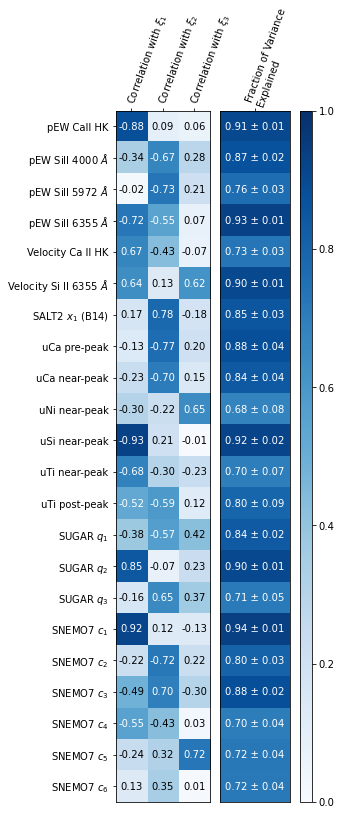

In [9]:
from matplotlib import colors
fig = plt.figure(figsize=(4.9, 12.), constrained_layout=False)

# left bottom width height
ax1 = fig.add_axes([0.26, 0.01, 0.45, 0.8])
ax2 = fig.add_axes([0.62, 0.01, 0.3, 0.8], sharey=ax1)
# cax = fig.add_subplot(gs[0, 2])

# fig, axes = plt.subplots(1, 3, sharey=True, figsize=(4.0, 10), gridspec_kw={'width_ratios': (3, 1, 1)}, constrained_layout=False)
# fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)

# cmap1 = a.settings['colormap']
# cmap1 = a.settings['colormap']
# sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=-1, vmax=1))
# sm1._A = []

# Make a truncated colormap
# cmap2 = plt.cm.Purples
cmap2 = plt.cm.Blues
# cmap2 = colors.LinearSegmentedColormap.from_list('unexp_var_cmap', cmap2(np.linspace(0., 0.8, 100)))
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0., vmax=1.))
sm2._A = []

def do_plot(ax, ax_data, sm, xlabels, ylabels=None, data_errs=None, threshold=0.5, aspect=1.):
    ax_data = np.atleast_2d(ax_data)
    im = ax.imshow(sm.to_rgba(np.abs(ax_data)), interpolation='nearest', aspect=aspect, vmin=-1, vmax=1)
    ax.set(
        xticks=np.arange(ax_data.shape[1]),
        yticks=np.arange(ax_data.shape[0]),
        xticklabels=xlabels,
    )

    if ylabels is not None:
        ax.set_yticklabels(ylabels)
    else:
        ax.tick_params(axis='y', which='both', left=False, right=False)

    # Ticks on top
    ax.get_xaxis().set_ticks_position('top')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=70, ha="left", va='center',
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    for i in range(ax_data.shape[0]):
        for j in range(ax_data.shape[1]):
            if data_errs is not None:
                label = f'{ax_data[i, j]:.2f} ± {data_errs[i, j]:.2f}'
            else:
                label = f'{ax_data[i, j]:.2f}'
            ax.text(j, i, label, ha="center", va="center",
                    color="white" if np.sign(threshold) * np.abs(ax_data[i, j]) > threshold else "black")

# do_plot(ax1, norm_coefficients, sm1, ['Component 1 Amplitude', 'Component 2 Amplitude', 'Component 3 Amplitude'], labels)
do_plot(ax1, all_correlations, sm2, ['Correlation with $\\xi_1$', 'Correlation with $\\xi_2$', 'Correlation with $\\xi_3$'], labels)
# do_plot(ax2, all_explained_variances[:, None], sm2, ['Fraction of Variance\nExplained'], threshold=0.5)
# do_plot(ax2, np.array([all_explained_variances, all_transformed_correlations]).T, sm2, ['Fraction of Variance\nExplained', 'Transformed Correlation'])
do_plot(ax2, np.array([all_explained_variances]).T, sm2, ['Fraction of Variance\nExplained'], aspect=0.45, data_errs=np.array([all_explained_variance_uncertainties]).T)

ax2.tick_params(labelleft=False)

# cbar1 = fig.colorbar(sm1, ax=ax1, orientation='vertical', aspect=60, pad=0.05, ticks=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
# cbar1.ax.set_yticklabels(['-1', '', '', '', '', '0', '', '', '', '', '1'])
# cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', aspect=60, pad=0.05, ticks=[0, 0.25, 0.5, 0.75, 1])
# cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', aspect=60, pad=0.05, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', aspect=60, pad=0.1, ticks=[0., 0.2, 0.4, 0.6, 0.8, 1])
# cbar2.ax.set_yticklabels(['0', '', '0.5', '', '1'])

a.savefig('indicators_recovery.pdf', bbox_inches='tight', pad_inches=0)